In [1]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns


In [2]:
data_path = 'data_ddm.csv'
data = pd.read_csv(data_path)


mean accuracy per subject and per condition

In [3]:
# 'choice' to numerical values where 'correct' = 1 and otherwise = 0
data['correct'] = (data['choice'] == 'correct').astype(int)
mean_accuracy = data.groupby(['id', 'cond'])['correct'].mean().reset_index()

In [4]:
mean_accuracy

,id,cond,correct
0,1,anti,0.831169
1,1,pro,0.973333
2,10,anti,0.941176
3,10,pro,1.000000
4,11,anti,0.916667
...,...,...,...
343,o88,pro,1.000000
344,o89,anti,0.861111
345,o89,pro,0.990196
346,o9,anti,0.960396




subjects with overall mean accuracy > 50%

In [5]:
subject_means = mean_accuracy.groupby('id')['correct'].mean()
subjects_to_keep = subject_means[subject_means > 0.5].index

remove 8 subjects that didnt understand the task

In [6]:

filtered_mean_accuracy = mean_accuracy[mean_accuracy['id'].isin(subjects_to_keep)].reset_index(drop=True)


checks:

In [7]:
total_subjects = data['id'].nunique()
total_subjects

174

In [8]:
excluded_subjects = total_subjects - len(subjects_to_keep)
excluded_subjects

8

In [9]:
filtered_mean_accuracy #new table with means

,id,cond,correct
0,1,anti,0.831169
1,1,pro,0.973333
2,10,anti,0.941176
3,10,pro,1.000000
4,11,anti,0.916667
...,...,...,...
327,o88,pro,1.000000
328,o89,anti,0.861111
329,o89,pro,0.990196
330,o9,anti,0.960396


now excluding subjects whose accuracy in any condition is less than 50% (not the averaged one)

In [10]:
subjects_to_exclude = mean_accuracy[mean_accuracy['correct'] < 0.5]['id'].unique()
revised_filtered_mean_accuracy = mean_accuracy[~mean_accuracy['id'].isin(subjects_to_exclude)].reset_index(drop=True)
revised_filtered_mean_accuracy['age_group'] = revised_filtered_mean_accuracy['id'].apply(lambda x: 'old' if str(x).startswith('o') else 'young')

total_subjects_revised = data['id'].nunique()
excluded_subjects_revised = total_subjects_revised - revised_filtered_mean_accuracy['id'].nunique()
excluded_subjects_info_revised = f"Total subjects: {total_subjects_revised}, Excluded subjects: {excluded_subjects_revised}"

revised_filtered_mean_accuracy, excluded_subjects_info_revised


(      id  cond   correct age_group
 0      1  anti  0.831169     young
 1      1   pro  0.973333     young
 2     10  anti  0.941176     young
 3     10   pro  1.000000     young
 4     11  anti  0.916667     young
 ..   ...   ...       ...       ...
 315  o88   pro  1.000000       old
 316  o89  anti  0.861111       old
 317  o89   pro  0.990196       old
 318   o9  anti  0.960396       old
 319   o9   pro  1.000000       old
 
 [320 rows x 4 columns],
 'Total subjects: 174, Excluded subjects: 14')

In [11]:
excluded_subjects_revised

14

In [12]:
excluded_subjects_list = list(set(data['id'].unique()) - set(revised_filtered_mean_accuracy['id'].unique()))
excluded_subjects_list

['59',
 '66',
 '34',
 'o64',
 'o76',
 '53',
 '79',
 'o31',
 'o13',
 'o8',
 '50',
 '48',
 'o27',
 'o77']

 Two-way ANOVA with interaction term 

In [13]:
revised_filtered_mean_accuracy['id'] = revised_filtered_mean_accuracy['id'].astype('category')
revised_filtered_mean_accuracy['cond'] = revised_filtered_mean_accuracy['cond'].astype('category')
revised_filtered_mean_accuracy['age_group'] = revised_filtered_mean_accuracy['age_group'].astype('category')

In [14]:
model_revised = ols('correct ~ C(cond) * C(age_group)', data=revised_filtered_mean_accuracy).fit()
anova_results_revised = sm.stats.anova_lm(model_revised, typ=2)
anova_results_revised

,sum_sq,df,F,PR(>F)
C(cond),0.662337,1.0,86.834008,2.092984e-18
C(age_group),0.184687,1.0,24.212933,1.390722e-06
C(cond):C(age_group),0.057937,1.0,7.595677,6.190552e-03
Residual,2.410330,316.0,NaN,NaN


results:

Condition Effect: The difference in accuracy across conditions is significant (F(1,316)=86.83, p<.0001).

Age Group Effect: The difference in accuracy between age groups is also significant (F(1,316)=24.21, p<.0001).

Interaction Effect: The interaction between condition and age group significantly affects accuracy (F(1,316)=7.60, p=.006).

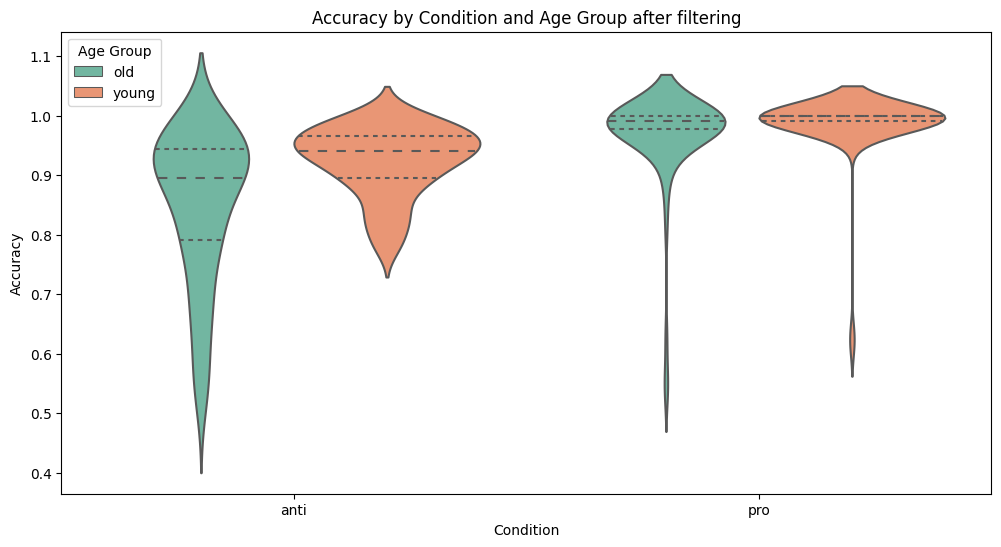

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.violinplot(x='cond', y='correct', hue='age_group', data=revised_filtered_mean_accuracy, split=False, inner="quartile", palette="Set2")
plt.title('Accuracy by Condition and Age Group after filtering')
plt.xlabel('Condition')
plt.ylabel('Accuracy')
plt.legend(title='Age Group', loc='upper left')
plt.show()
